In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

sns.set_context('talk')

# Data Preparation

In [2]:
df_raw = pd.read_csv("../data/online_retail_II.csv")
df_raw.shape

(1067371, 8)

In [3]:
df_raw.iloc[0]

Invoice                                     489434
StockCode                                    85048
Description    15CM CHRISTMAS GLASS BALL 20 LIGHTS
Quantity                                        12
InvoiceDate                    2009-12-01 07:45:00
Price                                         6.95
Customer ID                                13085.0
Country                             United Kingdom
Name: 0, dtype: object

In [4]:
df_raw['Customer ID'] = df_raw['Customer ID'].astype(str).apply(lambda x: x.split('.')[0])
df_raw['InvoiceDate'] = pd.to_datetime(df_raw['InvoiceDate'])
df_raw['subtotal'] = df_raw['Quantity'] * df_raw['Price']

In [5]:
## to remove hour and minute, convert to a date object
df_raw['invoice_date_week'] = pd.to_datetime(
    pd.to_datetime(df_raw['InvoiceDate']) - pd.to_timedelta(df_raw['InvoiceDate'].dt.dayofweek, unit='d')
).dt.date

## convert back to datetime object, so we can use it for pd.Grouper()
df_raw['invoice_date_week'] = pd.to_datetime(df_raw['invoice_date_week'])

In [6]:
from pandas.tseries.offsets import MonthEnd

df_raw['month_end_date'] = df_raw['InvoiceDate'] + MonthEnd(1)

In [7]:
print(f"Number of unique item codes: {df_raw['StockCode'].nunique():,}")

Number of unique item codes: 5,305


In [8]:
agg_date = df_raw.groupby(['StockCode']).agg({
    'invoice_date_week': ['min','max','nunique']
}).reset_index()

agg_date.columns = [
    col[0] if col[1] == '' else col[0]+'_'+col[1] for col in agg_date.columns
]

/home/elvyna/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


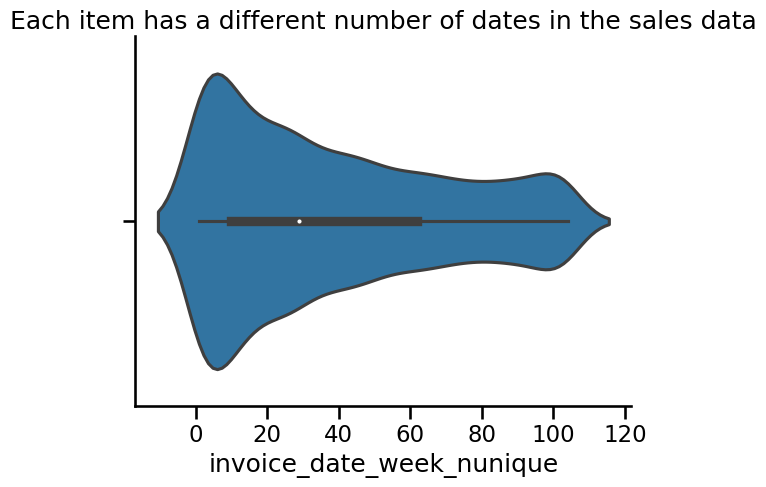

In [9]:
sns.violinplot(agg_date['invoice_date_week_nunique'])
plt.title('Each item has a different number of dates in the sales data')
sns.despine();

In [10]:
df_raw['Quantity'].describe()

count    1.067371e+06
mean     9.938898e+00
std      1.727058e+02
min     -8.099500e+04
25%      1.000000e+00
50%      3.000000e+00
75%      1.000000e+01
max      8.099500e+04
Name: Quantity, dtype: float64

In [11]:
negative_quantity = (df_raw['Quantity'] < 0).sum() / df_raw.shape[0] 
print(f"{negative_quantity:.2%} of the records have negative sales quantity")

2.15% of the records have negative sales quantity


Interesting -- the total sales quantity can be extremely negative. To simplify, we'll only take items with positive all-time sales quantity.

In [12]:
agg_quantity = df_raw.groupby('StockCode')['Quantity'].sum().sort_values().reset_index()
agg_quantity.head()

,StockCode,Quantity
0,20852,-18800
1,22126,-16400
2,23005,-14418
3,23003,-8516
4,10120,-8350


In [13]:
positive_quantity_item_list = agg_quantity.query('Quantity > 0')['StockCode'].tolist()
df_selected = df_raw.query('StockCode in @positive_quantity_item_list')

# Observe sales history

In [14]:
df_selected.iloc[0]

Invoice                                           489434
StockCode                                          85048
Description          15CM CHRISTMAS GLASS BALL 20 LIGHTS
Quantity                                              12
InvoiceDate                          2009-12-01 07:45:00
Price                                               6.95
Customer ID                                        13085
Country                                   United Kingdom
subtotal                                            83.4
invoice_date_week                    2009-11-30 00:00:00
month_end_date                       2009-12-31 07:45:00
Name: 0, dtype: object

In [15]:
df_agg = df_selected.groupby([
    pd.Grouper(
        key='invoice_date_week',
        freq='W'
    ),
    'StockCode'
])['Quantity'].sum().reset_index().rename(
    columns={
        'StockCode': 'stock_code',
        'Quantity': 'quantity'
    }
)

df_agg.head()

,invoice_date_week,stock_code,quantity
0,2009-12-06,10002,141
1,2009-12-06,10002R,1
2,2009-12-06,10080,4
3,2009-12-06,10123C,4
4,2009-12-06,10123G,2


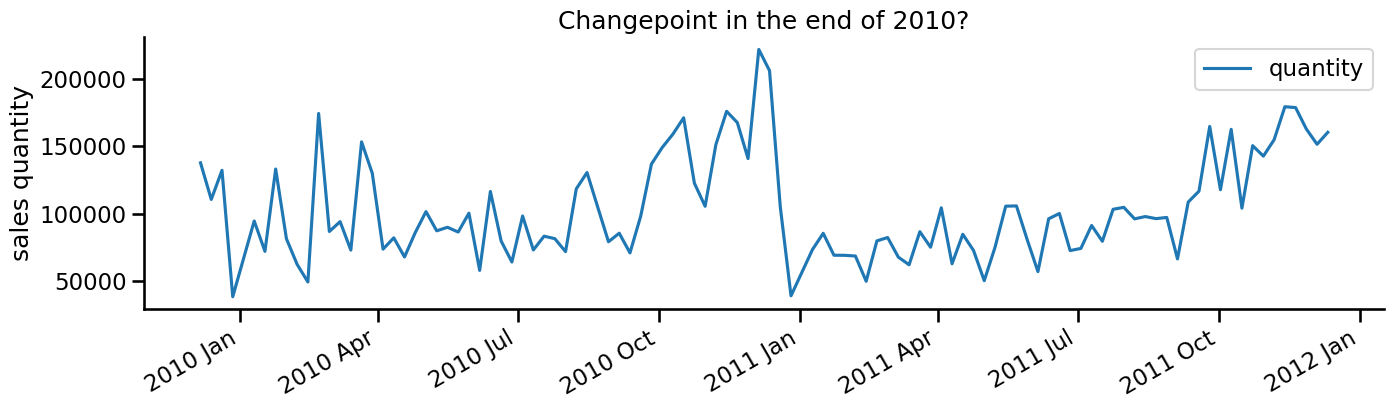

In [16]:
f, ax = plt.subplots(figsize=(16, 4))

_df = df_agg.groupby('invoice_date_week')['quantity'].sum().reset_index()

_df.plot(
    x='invoice_date_week',
    y='quantity',
    ax=ax,
    kind='line'
)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))
ax.set_xlabel('')
ax.set_ylabel('sales quantity')
plt.title("Changepoint in the end of 2010?")
sns.despine();

## Generate complete time series

In [24]:
from utils.preprocess_time_series import generate_complete_records

GENERATE_SERIES = False
SERIES_FILE_NAME = '../data/weekly-item-full-series.parquet'

if GENERATE_SERIES:
    df_agg_full = generate_complete_records(df=df_agg, date_freq='W')    
    df_agg_full.to_parquet(SERIES_FILE_NAME)
else:
    df_agg_full = pd.read_parquet(SERIES_FILE_NAME)
    
assert df_agg_full['quantity'].sum() == df_agg['quantity'].sum(), "Different values after generating complete records!"

In [25]:
mask = (df_agg_full['stock_code'] == '10002')
df_agg_full[mask]

,invoice_date_week,stock_code,quantity
0,2009-12-06,10002,141.0
1,2009-12-13,10002,24.0
2,2009-12-20,10002,37.0
3,2009-12-27,10002,14.0
4,2010-01-03,10002,0.0
...,...,...,...
101,2011-11-13,10002,0.0
102,2011-11-20,10002,0.0
103,2011-11-27,10002,0.0
104,2011-12-04,10002,0.0


## Observe new time series data

In [26]:
agg_quantity.tail()

,StockCode,Quantity
5300,84879,80705
5301,21212,95450
5302,85099B,95739
5303,85123A,96066
5304,84077,108545


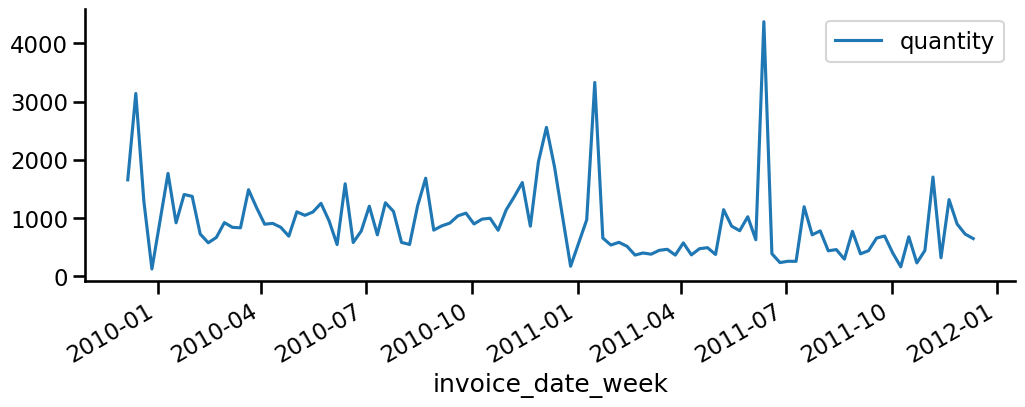

In [27]:
f, ax = plt.subplots(figsize=(12,4))

SELECTED_ITEM = '85123A'
df_agg.query('stock_code == @SELECTED_ITEM').plot.line(
    x='invoice_date_week', 
    y='quantity', 
    ax=ax
);
sns.despine();

# Clustering

## Approach 1: use summary statistics, then run common clustering algorithms

In [29]:
!pip install keras tensorflow graphviz pydot -q

In [89]:
df_agg_pivot = df_agg.pivot_table(
    index='stock_code',
    columns='invoice_date_week',
    values='quantity',
    fill_value=0
)
df_agg_pivot.head()

invoice_date_week,2009-12-06,2009-12-13,2009-12-20,2009-12-27,2010-01-10,2010-01-17,2010-01-24,2010-01-31,2010-02-07,2010-02-14,...,2011-10-09,2011-10-16,2011-10-23,2011-10-30,2011-11-06,2011-11-13,2011-11-20,2011-11-27,2011-12-04,2011-12-11
stock_code,,,,,,,,,,,,,,,,,,,,,
10002,141,24,37,14,15,191,41,44,16,43,...,0,0,0,0,0,0,0,0,0,0
10002R,1,0,2,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10080,4,0,0,0,0,0,0,0,0,0,...,0,4,0,2,24,46,16,27,0,0
10123C,4,16,124,0,0,3,13,14,-6,1,...,0,0,0,0,0,0,0,0,0,0
10123G,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
df_agg_pivot.values

array([[141,  24,  37, ...,   0,   0,   0],
       [  1,   0,   2, ...,   0,   0,   0],
       [  4,   0,   0, ...,  27,   0,   0],
       ...,
       [  0,   0,   3, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

In [91]:
df_agg_pivot.shape

(4710, 104)

In [114]:
%%timeit

# Reference: https://machinelearningmastery.com/lstm-autoencoders/
# Try reducing the dimensions via autoencoder

# lstm autoencoder recreate sequence
from keras.models import Sequential
from keras.models import Model
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model

# define input sequence
USE_SUBSET = True
if USE_SUBSET:
    input_sequence = df_agg_pivot.values[:50]
else:
    input_sequence = df_agg_pivot.values
    
# reshape input into [samples, timesteps, features]
n_sample = len(input_sequence)
n_input = df_agg_pivot.shape[1]
sequence = input_sequence.reshape((n_sample, n_input, 1))

# define model
model = Sequential()
model.add(LSTM(104, activation='relu', input_shape=(n_input, 1)))
model.add(RepeatVector(n_input))
model.add(LSTM(104, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(sequence, sequence, epochs=300, verbose=0)

# connect the encoder LSTM as the output layer
model = Model(inputs=model.inputs, outputs=model.layers[0].output)
plot_model(model, show_shapes=True, to_file='../report/lstm_encoder.png')

# get the feature vector for the input sequence
yhat = model.predict(sequence)
print(yhat.shape)
print(yhat)

2/2 [==============================] - 0s 14ms/step
(50, 104)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
2/2 [==============================] - 0s 14ms/step
(50, 104)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
2/2 [==============================] - 0s 16ms/step
(50, 104)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
2/2 [==============================] - 0s 14ms/step
(50, 104)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ..

In [126]:
sequence.shape

(1000, 104, 1)

In [132]:
# TODO: review

array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
      

## Approach 2: compute similarity measures of multiple time series

In [22]:
# import tslearn